In this project we are going to work with housing data for the city of Ames, Iowa, United States from 2006 to 2010.  We will use this data to build several regression models which could be used for predictive analysis on real estate prices.

We will start by setting up a pipeline of functions that will let us quickly iterate on different models.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
real_estate = pd.read_csv('AmesHousing.tsv',delimiter='\t')
real_estate.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


We will define some useful functions for our pipeline early on in the project so that we can add cells to the end of the notebook to do experiments and update the functions in these early cells.

In [40]:
#This function will be our transformation function; it will take in
#a data frame along with a desired cutoff value representing a
#tolerance for missing values in a column, and keep all columns that
#that have less than that percentage of missing values.
def transform_features(data, cutoff):
    drop_columns = list(data.isnull().sum()[(data.isnull().sum() > len(data)*cutoff)].index)
    #We also need to remove any columns that contain data leaks
    drop_columns += ['Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition',
                    'PID','Order']
    #We can also start looking to see which columns would be
    #unnecessary or superfluous for our model.  This is largely
    #subjective as we are not domain experts on real estate.
    drop_columns += ['Garage Yr Blt', 'Garage Finish', 'Garage Area',
                    'Garage Qual','Garage Cond','Misc Feature','Misc Val']
    drop_columns += ['MS SubClass', 'Overall Cond', 'BsmtFin SF 2',
                     'Bsmt Half Bath', 'Kitchen AbvGr', 'Enclosed Porch']
    transformed_df = data.drop(drop_columns,axis=1)
    #Based on testing, so far the column with the lowest number of non-null
    #values has about 2700 entries, which is only slightly less
    #than the length of our data set, making it a safer bet to 
    #simply drop those rows.  Let's fill all empty cells in int and
    #float columns with those columns' means and then drop everything
    #else.
    numeric_columns = transformed_df.dtypes[(transformed_df.dtypes == int) | (transformed_df.dtypes == float)].index
    for col in numeric_columns:
        transformed_df[col] = transformed_df[col].fillna(transformed_df[col].mean())
    transformed_df = transformed_df.dropna().reset_index(drop=True)
    #Now let's scale our features to enhance model performance
    scaling_cols = transformed_df.drop(['SalePrice'],axis=1).dtypes[(transformed_df.dtypes == int) | (transformed_df.dtypes == float)].index
    for col in scaling_cols:
        transformed_df[col] = (transformed_df[col] - transformed_df[col].min())/(transformed_df[col].max() - transformed_df[col].min())
    #Next, we can make a new column dealing with the lack of relevance
    #of the columns "Year Built" and "Year Remod/Add".
    #transformed_df['Years_Until_Remod'] = transformed_df['Year Remod/Add'] - transformed_df['Year Built']
    transformed_df = transformed_df.drop(['Year Remod/Add','Year Built'],axis=1)
    #Getting rid of categorical columns with low variance
    cat_cols = transformed_df.select_dtypes(exclude=[int,float]).columns
    for col in cat_cols:
        if transformed_df[col].value_counts().max() > len(transformed_df)*.9:
            del transformed_df[col]
    return transformed_df

In [4]:
#This function will be our feature selection function; it will
#return a list of features suitable for model training.
def select_features(data, coef=.4):
    #Let's update the function so that it takes a value as a minimum
    #coefficient to use for feature selection
    abs_corr = data.corr()['SalePrice'].abs()
    chosen_ones = abs_corr[abs_corr > coef].keys()
    return data[chosen_ones]

In [48]:
#This function will be our splitting, training, and testing pipeline
def train_and_test(data,k=0,coef=.4):
    if k == 0:
        train = data[:1460]
        test = data[1460:]
        num_train = select_features(train,coef)
        train_cols = num_train.drop(['SalePrice']).columns
        lr = LinearRegression()
        lr.fit(num_train[train_cols], num_train['SalePrice'])
        predictions = lr.predict(test[train_cols])
        rmse = np.sqrt(mean_squared_error(predictions, test['SalePrice']))
        return rmse
    elif k > 1: #Perform K-Fold Cross-Validation
        folds = k + 1
        test_size = int(len(data)/folds)
        rmse = 0
        final_data = select_features(data,.4)
        for k in range(folds):
            test_start = k*test_size
            test_end = (k+1)*test_size
            test = final_data.iloc[test_start:test_end]
            train = final_data.drop([x for x in range(test_start,test_end)],axis=0)
            chosen_cols = final_data.drop(['SalePrice'],axis=1).columns
            lr = LinearRegression()
            #Debugging print statements
            #print("final data: ",final_data.shape)
            #print("train: ",train.shape)
            #print("test: ",test.shape)
            #print("final data chosen cols: ",final_data[chosen_cols].shape)
            #print("final data sale price: ",final_data['SalePrice'].shape)
            #print("test chosen cols: ",test[chosen_cols].shape)
            #print("test sale price: ",test['SalePrice'].shape)
            lr.fit(train[chosen_cols], train['SalePrice'])
            predictions = lr.predict(test[chosen_cols])
            curr_rmse = np.sqrt(mean_squared_error(predictions, test['SalePrice']))
            rmse += curr_rmse
            print(curr_rmse)
        return rmse/folds

Here we will test the functions above as we iterate through improving our preprocessing pipeline.

In [41]:
tf_real_estate = transform_features(real_estate,.25)
tf_real_estate.head(10)

,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Condition 1,Bldg Type,House Style,...,TotRms AbvGrd,Fireplaces,Garage Type,Garage Cars,Wood Deck SF,Open Porch SF,3Ssn Porch,Screen Porch,Pool Area,SalePrice
0,RL,0.410959,0.142420,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,...,0.333333,0.50,Attchd,0.25,0.147472,0.108772,0.0,0.000000,0.0,215000
1,RH,0.202055,0.048246,Reg,Lvl,Inside,NAmes,Feedr,1Fam,1Story,...,0.166667,0.00,Attchd,0.00,0.098315,0.000000,0.0,0.208333,0.0,105000
2,RL,0.205479,0.060609,IR1,Lvl,Corner,NAmes,Norm,1Fam,1Story,...,0.250000,0.00,Attchd,0.00,0.275983,0.063158,0.0,0.000000,0.0,172000
3,RL,0.246575,0.046087,Reg,Lvl,Corner,NAmes,Norm,1Fam,1Story,...,0.416667,0.50,Attchd,0.25,0.000000,0.000000,0.0,0.000000,0.0,244000
4,RL,0.181507,0.058566,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,...,0.250000,0.25,Attchd,0.25,0.148876,0.059649,0.0,0.000000,0.0,189900
5,RL,0.195205,0.040562,IR1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,...,0.333333,0.25,Attchd,0.25,0.252809,0.063158,0.0,0.000000,0.0,195500
6,RL,0.068493,0.016920,Reg,Lvl,Inside,StoneBr,Norm,TwnhsE,1Story,...,0.250000,0.00,Attchd,0.25,0.000000,0.000000,0.0,0.000000,0.0,213500
7,RL,0.075342,0.017318,IR1,HLS,Inside,StoneBr,Norm,TwnhsE,1Story,...,0.166667,0.00,Attchd,0.25,0.000000,0.143860,0.0,0.250000,0.0,191500
8,RL,0.061644,0.019112,IR1,Lvl,Inside,StoneBr,Norm,TwnhsE,1Story,...,0.166667,0.25,Attchd,0.25,0.166433,0.266667,0.0,0.000000,0.0,236500
9,RL,0.133562,0.028979,Reg,Lvl,Inside,Gilbert,Norm,1Fam,2Story,...,0.333333,0.25,Attchd,0.25,0.098315,0.105263,0.0,0.000000,0.0,189000


In [7]:
tf_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680 entries, 0 to 2679
Data columns (total 46 columns):
MS Zoning          2680 non-null object
Lot Frontage       2680 non-null float64
Lot Area           2680 non-null int64
Lot Shape          2680 non-null object
Land Contour       2680 non-null object
Lot Config         2680 non-null object
Neighborhood       2680 non-null object
Condition 1        2680 non-null object
Bldg Type          2680 non-null object
House Style        2680 non-null object
Overall Qual       2680 non-null int64
Roof Style         2680 non-null object
Exterior 1st       2680 non-null object
Exterior 2nd       2680 non-null object
Mas Vnr Type       2680 non-null object
Mas Vnr Area       2680 non-null float64
Exter Qual         2680 non-null object
Exter Cond         2680 non-null object
Foundation         2680 non-null object
Bsmt Qual          2680 non-null object
Bsmt Exposure      2680 non-null object
BsmtFin Type 1     2680 non-null object
BsmtFin SF 1 

In [34]:
tf_real_estate['Bldg Type'].value_counts().max()

2259

We now have a very clean data set that still contains enough of the original entries to make for reliable training data.  We can now start engineering features.

In [9]:
tf_real_estate.dtypes

MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Lot Shape           object
Land Contour        object
Lot Config          object
Neighborhood        object
Condition 1         object
Bldg Type           object
House Style         object
Overall Qual         int64
Roof Style          object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
Bsmt Unf SF        float64
Total Bsmt SF      float64
Heating QC          object
1st Flr SF           int64
2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Bsmt Full Bath     float64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen Qual        object
TotRms AbvGrd        int64
F

Let's create a heatmap of the correlations to see which continuous features correlate strongly with SalePrice and which ones are worth getting rid of.

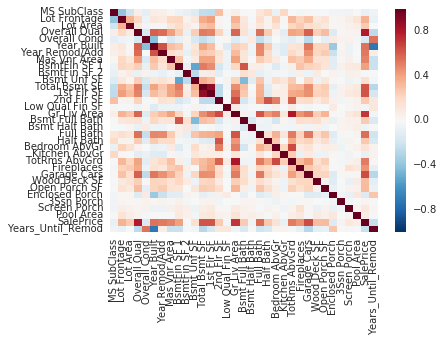

In [20]:
import seaborn as sns
%matplotlib inline
numeric_columns = tf_real_estate.dtypes[(tf_real_estate.dtypes == int) | (tf_real_estate.dtypes == float)].index
sns.heatmap(tf_real_estate[numeric_columns].corr())

It looks like the following are high-correlate pairs:
(Total Basement Square Feet, 1st Floor Living Area),
(Total Rooms Above Grade, Gr Living Area)

At a minimum, we should remove one from each of these pairs so as to keep our model clean from noise.  In addition, we have some more candidates for features worth dropping due to their low correlation with SalePrice, such as MS Subclass, Overall Cond, BsmtFin SF 2, Bsmt Half Bath, Kitchen AbvGr, Enclosed Porch, and even our newly added Years_Until_Remod.  We can update our transform_features function above with this new information.

Now we can start dealing with our categorical features.  All categorical variables are candidates for conversion to numerical ones, but first we should consider the expansion of our data fram categorical variables with many potential values would cause.  Furthermore, columns where over 90% of the entries are the same value will provide only low-variance data to our model.  Let's update our transformation function to get rid of those columns.

In [10]:
cat_cols = tf_real_estate.select_dtypes(exclude=[int,float]).columns
for col in cat_cols:   
    tf_real_estate[col] = tf_real_estate[col].astype('category')
    dummy_cols = pd.get_dummies(tf_real_estate[col])
    tf_real_estate = pd.concat([tf_real_estate,dummy_cols],axis=1)
    del tf_real_estate[col]

In [11]:
tf_real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2680 entries, 0 to 2679
Columns: 185 entries, Lot Frontage to Detchd
dtypes: float64(7), int64(17), uint8(161)
memory usage: 923.9 KB


Let's look at the correlation coefficients for SalePrice to ascertain which columns we would like to use in our training.

In [42]:
tf_real_estate.corr()['SalePrice'].abs().sort_values()

Low Qual Fin SF    0.028466
3Ssn Porch         0.030729
Pool Area          0.074464
Screen Porch       0.105308
Bedroom AbvGr      0.148856
Bsmt Unf SF        0.162316
Lot Area           0.261880
Bsmt Full Bath     0.263208
2nd Flr SF         0.264577
Half Bath          0.269236
Wood Deck SF       0.309380
Open Porch SF      0.317593
Lot Frontage       0.346531
BsmtFin SF 1       0.412915
Fireplaces         0.452613
Mas Vnr Area       0.499729
TotRms AbvGrd      0.523151
Full Bath          0.555480
Total Bsmt SF      0.630264
1st Flr SF         0.630419
Garage Cars        0.652383
Gr Liv Area        0.715441
Overall Qual       0.793249
SalePrice          1.000000
Name: SalePrice, dtype: float64

We can use this information to update our select_features() function.  Let's craft it so that the minimum coefficient is a hyperparameter.  For the purposes of this project, though, let's decide on .4 as a minimum coefficient to keep for training.

In [43]:
final_data = select_features(tf_real_estate,.4)
final_data.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,SalePrice
0,0.500,0.0700,0.113218,0.162365,0.266425,0.238586,0.25,0.333333,0.50,0.25,215000
1,0.375,0.0000,0.082920,0.129392,0.104309,0.093410,0.25,0.166667,0.00,0.00,105000
2,0.500,0.0675,0.163536,0.203830,0.196672,0.176122,0.25,0.250000,0.00,0.00,172000
3,0.625,0.0000,0.188696,0.333888,0.363268,0.325310,0.50,0.416667,0.50,0.25,244000
4,0.375,0.0000,0.140149,0.137052,0.111135,0.233429,0.50,0.250000,0.25,0.25,189900


Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add to our train_and_test() function a parameter named k that controls what type of cross validation occurs.  Since the function also contains the select_features(), which takes an optional value as a minimum coefficient, e will also update train_and_test() so that it too will take that optional value and pass it to select_features(). We will test our final train_and_test() function below.

In [22]:
final_rmse = train_and_test(tf_real_estate,3,.4)
final_rmse

final data:  (2680, 57)
train:  (2010, 57)
test:  (670, 57)
final data chosen cols:  (2680, 678)
final data sale price:  (2680,)
test chosen cols:  (670, 678)
test sale price:  (670,)
final data:  (2680, 57)
train:  (2010, 57)
test:  (670, 57)
final data chosen cols:  (2680, 678)
final data sale price:  (2680,)
test chosen cols:  (670, 678)
test sale price:  (670,)
final data:  (2680, 57)
train:  (2010, 57)
test:  (670, 57)
final data chosen cols:  (2680, 678)
final data sale price:  (2680,)
test chosen cols:  (670, 678)
test sale price:  (670,)
final data:  (2680, 57)
train:  (2010, 57)
test:  (670, 57)
final data chosen cols:  (2680, 678)
final data sale price:  (2680,)
test chosen cols:  (670, 678)
test sale price:  (670,)


32926.885317864784

In this test run with a minimum coefficient of .4 and a k-value of 3, our RMSE was almost 33,000.  Let's run our train_and_test() a few more times with different parameters and without the debugging print statements.

In [24]:
final_rmse = train_and_test(tf_real_estate,5,.4)
final_rmse

32036.49199949774

By increasing our k-value by 2, we have decreased our RMSE by about 3,000.  Let's add some verbosity to our train_and_test so that we can see each RMSE value as it trains, and then run it again.

In [26]:
final_rmse = train_and_test(tf_real_estate,8,.4)
final_rmse

27755.516738159164
31357.352424922257
26329.442939080644
24955.145433241607
42311.48572981938
38757.863770877564
45565.72331686585
31771.329051348726
25868.629574104685


32741.387664268874

It looks like we have a lot of variance in our RMSEs, which is a sign of overfitting.  Let's try increasing our minimum coefficient.

In [27]:
final_rmse = train_and_test(tf_real_estate,5,.6)
final_rmse

31533.88720387897
26144.879845388925
24328.75476657506
42495.72546376523
40477.91264810694
27237.792069271298


32036.49199949774

In [28]:
final_rmse = train_and_test(tf_real_estate,8,.7)
final_rmse

27755.516738159164
31357.352424922257
26329.442939080644
24955.145433241607
42311.48572981938
38757.863770877564
45565.72331686585
31771.329051348726
25868.629574104685


32741.387664268874

We also have not normalized our data set yet.  Let's add min-max normalization to transform_df() and see if that has an effect on our model's performance.

In [44]:
final_rmse = train_and_test(tf_real_estate,5,.4)
final_rmse

37498.966155713715
28368.32727067672
30509.76591460875
45717.03784916207
43886.53181632384
31137.026641389024


36186.27594131236

In [45]:
final_rmse = train_and_test(tf_real_estate,8,.7)
final_rmse

31624.545670439384
37886.680413249895
27898.542552670333
31542.460417735245
46293.01227092007
42071.575571501526
47677.1617004019
36478.80826628991
30444.374545234572


36879.68460093809

In [47]:
final_rmse = train_and_test(tf_real_estate,20,.6)
final_rmse

36304.023173510795
26113.488534603854
32977.819552438574
44671.28258546248
30578.49460799933
27438.973841340103
27012.161123369613
34698.21582999079
31165.96190758213
26340.188544072902
62007.24757745803
37919.03838291878
50501.50807024306
25008.370970430133
29648.74242796142
63365.81108117608
42255.2840214056
34385.48683302818
27694.501956269793
29911.659544156577
30005.54236809719


35714.46680635789

There are three major takeaways from this project:

1) Without finding a way to efficiently and accurately capture relevant categorical features, it becomes very difficult to reduce the RMSE and thus improve our model's performance.

2) We also have very little training data to work with; even before we dropped about 20% of our entries, we still had barely 3,000 individual sales that we could teach our model with.  The two biggest limiting factors behind model performance regardless of how well tuned it is are dirty data and scarce data.

3) Upon scaling down our features, our model's training speed increased by SEVERAL FOLD.  This is one more reason, even beyond improving model accuracy, it is always a good idea to normalize and scale features.